# Car Racing DQN agent 
Training a DQN agent for the OpenAI gym Car-Racing-v0 environment.

### Environment setup

        conda create -c conda-forge -n gymenv swig pip  
        conda activate gymenv  
        pip install gym==0.19   # Use 0.17.3 to render in the notebook, however this has memory leak issues because of xvfb
        pip install Box2D gym
        pip install gym[all]

        pip install tensorflow
        pip install matplotlib

        pip install gym pyvirtualdisplay   
        sudo apt-get install -y xvfb python-opengl ffmpeg  

        # The following steps are so that I can access the new env in Azure ML notebooks
        conda install ipykernel
        python -m ipykernel install --user --name gymenv --display-name "Python (gymenv)"




### Useful links

#### Papers
https://arxiv.org/pdf/1312.5602.pdf   
https://arxiv.org/pdf/1509.06461v3.pdf 

#### Environment setup  
https://stackoverflow.com/questions/60268769/gyms-box-2d-openai-doesnt-install-successfully-pip-error  
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-access-terminal#add-new-kernels  

#### Code examples
https://keras.io/examples/rl/deep_q_network_breakout/  
https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c  
https://pythonprogramming.net/training-deep-q-learning-dqn-reinforcement-learning-python-tutorial/?completed=/deep-q-learning-dqn-reinforcement-learning-python-tutorial/   
https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN  
https://github.com/pekaalto/DQN 

#### DDQN
https://ai.stackexchange.com/questions/22609/how-does-the-target-network-in-double-dqns-find-the-maximum-q-value-for-each-act 

#### Other
https://adgefficiency.com/dqn-tuning/ 
https://web.stanford.edu/class/cs234/CS234Win2018/slides/cs234_2018_l6.pdf
https://greentec.github.io/reinforcement-learning-third-en/#fn:4
https://stackoverflow.com/questions/59737875/keras-change-learning-rate  
https://ai.stackexchange.com/questions/12268/in-q-learning-shouldnt-the-learning-rate-change-dynamically-during-the-learnin  
https://stackoverflow.com/questions/51960225/dqn-average-reward-decrease-after-training-for-a-period-of-time  
https://stackoverflow.com/questions/52770780/why-is-my-deep-q-net-and-double-deep-q-net-unstable  
https://greentec.github.io/reinforcement-learning-third-en/#double-dqn 


#### Import libraries

In [1]:
import gym
import numpy as np
from gym.wrappers import Monitor
from IPython.display import HTML
from pyvirtualdisplay import Display
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from collections import deque
import time
import random
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, \
                        GlobalMaxPool2D, BatchNormalization, Dropout, Activation
from keras.backend import clear_session

from dqn_agent import *
from dqn_agent_trainer import *
from utils import *
from cnn_utils import *

display = Display(visible=0, size=(1400, 900))
display.start()

## Train the DQN agent

In [2]:
# Define action set
actions = np.array([[0.0, 1.0, 0.0],
                    [1.0, 0.0, 0.0],
                    [-1.0, 0.0, 0.0],
                    [0.0, 0.0, 0.8],
                    [0.0, 0.0, 0.0]]   
                )

# Define action probabilities
action_probs = np.array([0.5] + [(1 - 0.5)/4.0] * 4)


def modified_cnn_model(img_dim, learning_rate, num_actions):
    """Returns a CNN model - simplified architecture from DeepMind paper."""

    model = Sequential()
    model.add(Conv2D(32, 8, activation='relu', strides=4, input_shape=img_dim))
    model.add(Conv2D(64, 4, activation='relu', strides=2))
    model.add(Conv2D(64, 3, activation='relu', strides=1))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_actions, activation="linear"))

    opt = Adam(learning_rate=learning_rate, epsilon=1e-7, clipnorm=1.0)
    loss_function = keras.losses.Huber()
    model.compile(loss=loss_function, optimizer=opt, metrics=['mean_squared_error'])

    return model


# Create a DQN agent
dqn_agent = DQNAgent(actions,
                    action_probs,
                    lr=0.00025, 
                    batch_size=32,
                    gamma=0.95,
                    tau=0.005,
                    user_defined_model_function=modified_cnn_model,
                    ddqn=True)


# Load benchmark rewards
run = "./runs/20220418-072859/config_results.pickle"
with open(run, 'rb') as fp:
    results = pickle.load(fp)
benchmark_rewards = results['episode_rewards']

# Create the agent trainer
agent_trainer = DQNAgentTrainer(img_len=96, 
                                frame_stack_num=4, 
                                number_of_episodes=1000, 
                                epsilon=0.05, 
                                epsilon_min=0.005, 
                                epsilon_step_episodes=50.0,
                                first_epsilon_decay_episode=300,
                                final_epsilon_episode=10000,
                                max_replay_memory_size=100000, 
                                min_replay_memory_size=1000, 
                                random_action_steps=5000,
                                max_consecutive_negative_rewards=150, 
                                update_target_model_steps=1, 
                                target_model_hard_update=False,
                                max_steps_per_episode=10000,
                                skip_frames=4, 
                                save_model_frequency=200, 
                                save_models=True, 
                                save_run_results=True,
                                verbose_cnn=50, 
                                verbose=True,
                                plot_progress=True,
                                benchmark_rewards=benchmark_rewards)


2022-04-21 06:19:10.441859: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-21 06:19:10.441935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (blockade-runner): /proc/driver/nvidia/version does not exist
2022-04-21 06:19:10.442624: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Episode: 38
Ending episode: done True, consecutive negative rewards 16
Total steps in episode: 56
Replay buffer size: 6144
Total step count: 6144
Epsilon: 0.05
Total reward for episode: 20.035766423358766
Running average rewards: -25.98793338211862 



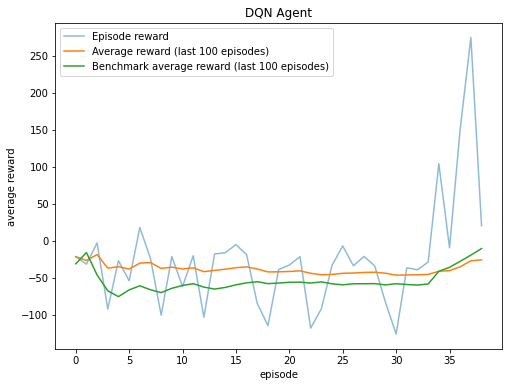

Track generation: 1283..1608 -> 325-tiles track
1/1 [==============================] - 0s 11ms/step - loss: 0.1485 - mean_squared_error: 0.8422


In [ ]:
# Init environment and train agent
env = gym.make("CarRacing-v0")
agent_trainer.train_agent(env, dqn_agent)

### Render the DQN agent

In [4]:
with open("./runs/dqn_results_20220412-110508.pickle", 'rb') as fp:
    results = pickle.load(fp)

actions = results['actions']
model = results['model']
env = wrap_env(gym.make("CarRacing-v0"))

# Reset environment and process image
s_0 = env.reset()
s_0 = image_processing(s_0, 96)
grayscale_state_buffer = deque([s_0]*13)
s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

episode_rewards = 0

i = 0
while True:
    # Full throttle for first 50 frames
    if i < 50:
        a_0 = 0
    else:
        a_0 = np.argmax(model.predict(s_0_stacked))
    s_1, reward, done, _ = env.step(actions[a_0])
    episode_rewards += reward

    if done:
        break

    # Append latest state and get new stacked representation
    s_1 = image_processing(s_1, 96)
    grayscale_state_buffer.append(s_1)
    s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

    i += 1

# Append rewards
print(episode_rewards)
show_video()
env.close()

In [28]:
# with open("./runs/dqn_results_20220411-040945.pickle", 'rb') as fp:
#     results = pickle.load(fp)

# actions = results['actions']
# model = results['model']


def live_trial(episodes, env, render=False):
    """Do a live trial."""

    total_rewards = []

    for episode in range(episodes):
        episode_rewards = 0

        # Reset environment and process image
        s_0 = env.reset()
        s_0 = image_processing(s_0, 96)
        grayscale_state_buffer = deque([s_0]*13)
        s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

        i = 0
        while True:
            # Full throttle for first 50 frames
            if i < 50:
                a_0 = 0
            else:
                a_0 = np.argmax(model.predict(s_0_stacked))
            s_1, reward, done, _ = env.step(actions[a_0])
            episode_rewards += reward

            if done:
                break

            # Append latest state and get new stacked representation
            s_1 = image_processing(s_1, 96)
            grayscale_state_buffer.append(s_1)
            s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

            i += 1

        # Append rewards
        print(episode_rewards)
        total_rewards.append(episode_rewards)

    env.close()
    return total_rewards


env = gym.make("CarRacing-v0")
total_rewards = live_trial(5, env, render=False)



Track generation: 998..1259 -> 261-tiles track
838.461538461519
Track generation: 935..1173 -> 238-tiles track
945.099999999995
Track generation: 1108..1393 -> 285-tiles track
871.8309859154715
Track generation: 1040..1304 -> 264-tiles track
888.5931558935131
Track generation: 1081..1355 -> 274-tiles track
878.0219780219633


### CNN activation analysis 

In [3]:
with open("./runs/dqn_results_20220412-110508.pickle", 'rb') as fp:
    results = pickle.load(fp)

actions = results['actions']
model = results['model']

In [4]:
def live_trial(env, model):
    """Do a live trial."""

    # Reset environment and process image
    s_0 = env.reset()
    s_0 = image_processing(s_0, 96)
    grayscale_state_buffer = deque([s_0]*13)
    s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

    state_list = []
    i = 0
    while True:
        if i%10 == 0:
            state_list.append(s_0_stacked)
        # Full throttle for first 50 frames
        if i < 50:
            a_0 = 0
        else:
            a_0 = np.argmax(model.predict(s_0_stacked))
        s_1, reward, done, _ = env.step(actions[a_0])

        if done:
            break

        # Append latest state and get new stacked representation
        s_1 = image_processing(s_1, 96)
        grayscale_state_buffer.append(s_1)
        s_0_stacked = get_stacked_state_live(grayscale_state_buffer, (96, 96, 4), 4)

        i += 1

    env.close()

    return state_list

env = gym.make("CarRacing-v0")
state_list = live_trial(env, model)

# Create activation model
activation_model = create_activation_model(model)

Track generation: 1019..1279 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1151..1451 -> 300-tiles track


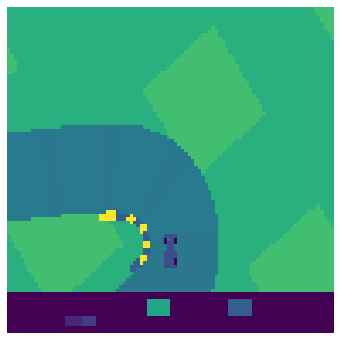

In [11]:
# Select image index from history
idx = 44
img = state_list[idx][:, :, :, :]

# Plot an image
plt.figure(figsize=(6, 6))
plt.imshow(img[0, :, :, 3])
plt.axis('off')
plt.show()

conv2d


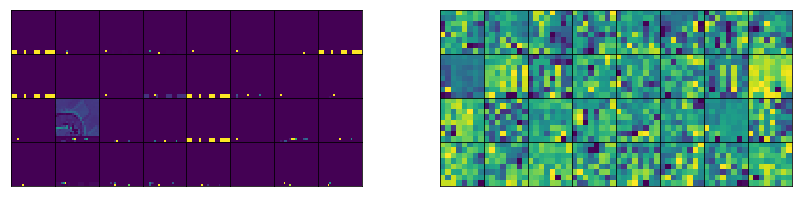

conv2d_1


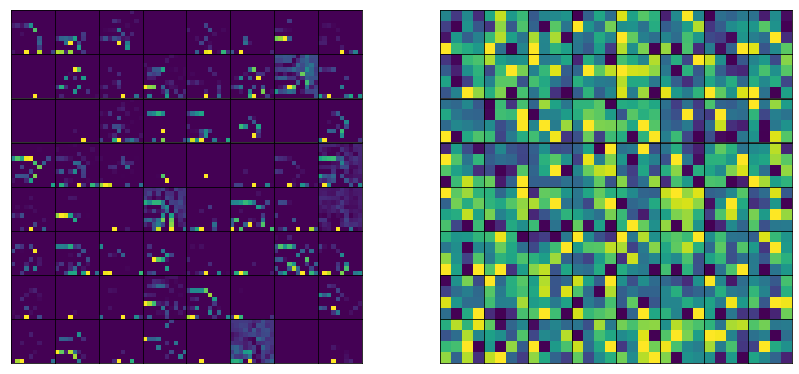

conv2d_2


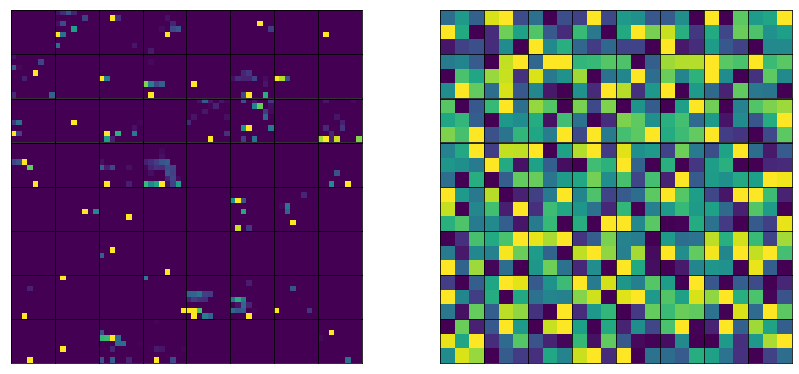

In [12]:
# Feature maps and filters for state
display_cnn_feature_maps_and_filters(model, activation_model, img, total_width=14, cmap='viridis')